In [1]:
import numpy as np
import librosa
import pylab
from os import listdir
from os.path import isfile, join
import os


import matplotlib.pyplot as plt
import scipy.fftpack

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from scipy.signal import freqz
import noisereduce as nr

from sklearn.model_selection import train_test_split

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

C:\Anaconda3\lib\site-packages\numba\errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
C:\Anaconda3\lib\site-packages\noisereduce\noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Data Loading

In the following I retrieve the file locations of all of the audio clips

In [2]:
top_folder_location = os.path.abspath(os.getcwd()) + "\Data"

In [3]:
def getAudioFromFolderNumber(number):
    folder_location = top_folder_location + '\\' + str(number) + '\\audio'
    file_names = [f for f in listdir(folder_location) if isfile(join(folder_location, f))]
    file_locations = [folder_location+'\\'+f for f in file_names]
    return file_locations

In [4]:
file_names = [f for f in listdir(top_folder_location) if isfile(join(top_folder_location, f))]
all_folder_locations = sorted([int(f) for f in listdir(top_folder_location)])

In [5]:
audio_locations = []
for folder_no in all_folder_locations:
    audio_locations.extend(getAudioFromFolderNumber(folder_no))

# Denoising

### First Attempt - Using a Bandpass filter to cut out unwanted frequencies

I first took a naive approach to denoising the audio and that was to simply use a bandpass filter to cut out the frequencies associated with the noise

In [6]:
test_audio, sr = librosa.load(audio_locations[0]) # Try with the first audio clip

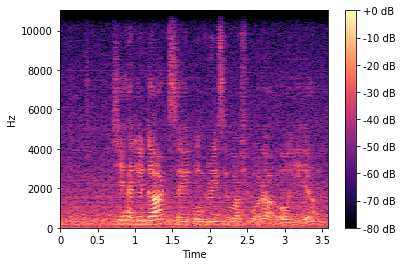

In [7]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(test_audio)), ref=np.max)

librosa.display.specshow(D, y_axis='linear', x_axis='time')
plt.colorbar(format='%+2.0f dB')

My guess was then that maybe if I could use a bandpass filter to remove the frequencies below 500Hz and above 10,000Hz I could improve the audio quality

In [8]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [9]:
lowcut=500
highcut=10000
y = butter_bandpass_filter(test_audio, lowcut, highcut, sr, order=6)

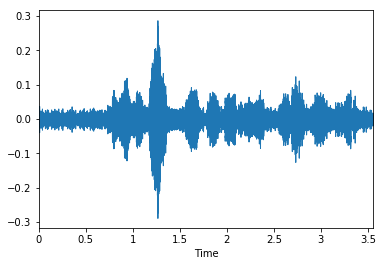

In [10]:
librosa.display.waveplot(test_audio, sr=sr)
ipd.Audio(test_audio, rate=sr)

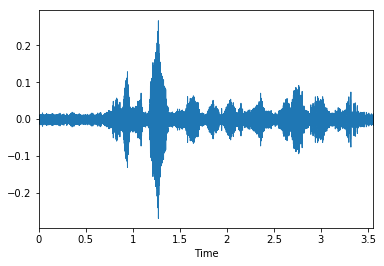

In [11]:
librosa.display.waveplot(y, sr=sr)
ipd.Audio(y, rate=sr)

Although it appears to have given us a sharper looking waveform, we can hear that if anything the speaker's voice seems more distant, almost asif its blended with the noise after using the (naive) bandpass filter. 

### Second Attempt - Using Spectral Gating Library to Denoise

Spectral Gating appears to be a much better solution to this. Its works by ananlysing a sample clip of the noise and then calculating various statistics using the frequencies presented in the noise sample. Using these frequencies a mask is created and then applied to the audio clip. In the interest of time I imported a library that does all of this (taken from https://timsainburg.com/noise-reduction-python.html).

In [12]:
def denoiseaudio(audio_location):
    x, sr = librosa.load(audio_location)
    
    noise_sample = x[0:10000] # Typically in the first few moments of each clip contains just noise. We sample this moment from each clips and feed it to the denoiser
    # perform noise reduction
    reduced_noise = nr.reduce_noise(audio_clip=x, noise_clip=noise_sample, verbose=False)
    
    return x, reduced_noise, sr

In [13]:
denoised_audios = []
mfcc_values = []

In [14]:
for i,f in enumerate(audio_locations):
    waveform, reduced_noise, sr = denoiseaudio(f)
    librosa.output.write_wav(str(i) + '.wav', reduced_noise, sr)
     
    denoised_audios.append(reduced_noise)
    
    mfcc_values.append(librosa.feature.mfcc(reduced_noise, sr, n_mfcc=40))

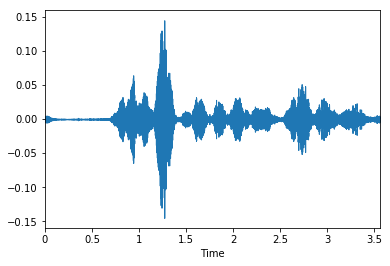

In [15]:
librosa.display.waveplot(denoised_audios[0], sr=sr)
ipd.Audio(denoised_audios[0], rate=sr)

In the example waveform above we see that it appears to have produced a much cleaner waveform. The noise is also absent in the audio now.

# Feature Extraction

In order to extract features from the denoised audio clips I looked at some standard feature extraction techniques. A naive approach would be use the fourier transform values. A much better approach I read (http://www.speech.cs.cmu.edu/15-492/slides/03_mfcc.pdf) was to use Mel-frequency cepstral coefficients which capture frequencies that humans are sensitive to and translate them to a Mel Scale. 

In [16]:
shortest_clip_size = np.min([m.shape[1] for m in mfcc_values])

Because the audio files are of different lengths we clips all the files at the end so they all audio clips are as long as the shortest audio clip in the dataset.

In [17]:
mfcc_values_clipped = []
for m in mfcc_values:
    mfcc_values_clipped.append(m[:,0:shortest_clip_size])
    
X = np.array(mfcc_values_clipped)

MFCC values are provided frame by frame.  This means we have a 2 dimensional array for each audio clip (i.e we have MFCC values for each frame in the audio clip). In order to get these features to work with traditional ML algorithms we would need a 2d representation. To this end I chose to average the MFCC coefficients across all frames. 

In [18]:
mfcc_values_clipped_averaged = np.array([np.mean(m, axis=1) for m in mfcc_values_clipped])

The audio data was clearly segregated by gender, with the first 1/2 of the files being provided by females and the second by males. We use this to give binary labels for each audio clip

In [19]:
# first 160 recordings are female. Use 0 for female and 1 for male 
y = np.array(([0] * 160) + ([1] * (len(denoised_audios) - 160)))

In [20]:
X = mfcc_values_clipped_averaged

# Model Training

In this section we trial out a number of standard ML algorithms. We split our datasetup into a 70:30 training:testing split. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state=True, shuffle=True)

In [22]:
X_train.shape

(245, 40)

In [23]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

target_names = ['female', 'male']

In [24]:
svm_clf = svm.SVC()
svm_clf.fit(X_train, y_train)
accuracy_score(y_test, svm_clf.predict(X_test))

print('SVM Performance:\n')
print(classification_report(y_test, svm_clf.predict(X_test), target_names=target_names))

SVM Performance:

              precision    recall  f1-score   support

      female       0.93      0.84      0.88        45
        male       0.89      0.95      0.92        60

    accuracy                           0.90       105
   macro avg       0.91      0.90      0.90       105
weighted avg       0.91      0.90      0.90       105



In [25]:
rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rfc.fit(X_train, y_train)
accuracy_score(y_test, rfc.predict(X_test))
print('Random Forest Performance:\n')
print(classification_report(y_test, rfc.predict(X_test), target_names=target_names))

Random Forest Performance:

              precision    recall  f1-score   support

      female       0.96      1.00      0.98        45
        male       1.00      0.97      0.98        60

    accuracy                           0.98       105
   macro avg       0.98      0.98      0.98       105
weighted avg       0.98      0.98      0.98       105



In [26]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
accuracy_score(y_test, gnb.predict(X_test))
print('Naive Bayes Performance:\n')
print(classification_report(y_test, gnb.predict(X_test), target_names=target_names))

Naive Bayes Performance:

              precision    recall  f1-score   support

      female       1.00      1.00      1.00        45
        male       1.00      1.00      1.00        60

    accuracy                           1.00       105
   macro avg       1.00      1.00      1.00       105
weighted avg       1.00      1.00      1.00       105



In [27]:
printmd("**Training Performance Summary:**")
printmd("*SVM Accuracy:*")
print(accuracy_score(y_train, svm_clf.predict(X_train)))

printmd("*Random Forest Accuracy:*")
print(accuracy_score(y_train, rfc.predict(X_train)))

printmd("*Naive Bayes Accuracy:*")
print(accuracy_score(y_train, gnb.predict(X_train)))

**Training Performance Summary:**

*SVM Accuracy:*

0.8857142857142857


*Random Forest Accuracy:*

1.0


*Naive Bayes Accuracy:*

0.9877551020408163


In [28]:
printmd("**Testing Performance Summary:**")
printmd("*SVM Accuracy:*")
print(accuracy_score(y_test, svm_clf.predict(X_test)))

printmd("*Random Forest Accuracy:*")
print(accuracy_score(y_test, rfc.predict(X_test)))

printmd("*Naive Bayes Accuracy:*")
print(accuracy_score(y_test, gnb.predict(X_test)))

**Testing Performance Summary:**

*SVM Accuracy:*

0.9047619047619048


*Random Forest Accuracy:*

0.9809523809523809


*Naive Bayes Accuracy:*

1.0


# Summary

In summary Spectral gating was used to denoise the audio. MFCC values where used to extract features from each audio clip. In ordet to produce a 2d compact representation of each MFCC array I chose to average over the MFCC array 